# Linear Regression


## Import

In [145]:
import numpy as np
import torch
import statsmodels.api as sm
import sklearn.linear_model as skl

# Pytorch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
plt.rcParams["animation.html"] = "jshtml"

## Synthetic Data Generation with Numpy

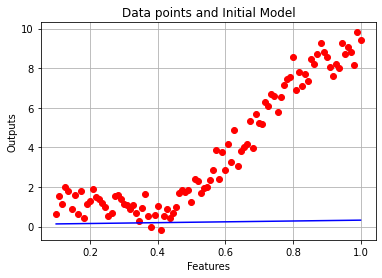

In [146]:
# Independent variable (100, 1)
x = np.linspace(1.0, 10.0, 100)[:, np.newaxis]

# Length of the dataset
n = len(x)

# Dependent variable (100, 1)
y = np.sin(x) + 0.1*np.power(x,2) + 0.5*np.random.randn(100,1)

# Normalization for the numerical stability of the algorithm
x /= np.max(x)

# Trick: do not carry the bias among the calculation
# Add a new column to the feature vector (100, 2)
x_trick = np.hstack((np.ones_like(x), x))

# Initialize the W parameters
# Trick: bias included in the weight matrix (2, )
W = np.random.rand(2)

# Plot the data and the initial model
plt.plot(x, y, 'ro',
         x, x_trick.dot(W), 'b')
plt.grid(True)
plt.xlabel('Features')
plt.ylabel('Outputs')
plt.title('Data points and Initial Model')
plt.show()



### Numpy Implementation

#### Gradient Function

In [147]:
def get_gradient(W,x,y):
    """Compute gradient and cost
    
    Parameters
    ----------
    W : np.array, size (num_of_features, 1)
        Parameters of the model
    x : np.array, size (num_of_samples, num_of_features)
        Matrix of the input data
    y : np.array, size (num_of_samples, 1)
        Vector of the output values 
    
    """
    # Get the number of samples
    n = x.shape[0]
    
    # Perform the prediction
    y_hat = x.dot(W).flatten()

    # Compute the loss
    loss = y_hat - y.flatten()
    
    # Compute the cost
    cost = np.sum(np.power(loss, 2)) / (2 * n)
    
    # Compute the gradient (dcost/dW)
    gradient = loss.dot(x) / n
    
    return gradient, cost


#### Gradient Descent

In [148]:
# Set the hyperparameters
lr = 0.5
tolerance = 1e-5

print('----- Parameters to be optimized:')
print('W:')
print(W[1])
print()
print('b:')
print(W[0])

# Variable for visualization
W_updates = []
W_updates.append(W)

# Perform the gradient descent
iterations = 1
print('\n----- Start training...')
while True:
    gradient, error = get_gradient(W, x_trick, y)
    W_updated = W - lr * gradient
    W_updates.append(W_updated)

    # Stopping condition
    # Check if the model change significantly
    if np.sum(abs(W_updated - W)) < tolerance:
        print('-----Converged')
        break

    if iterations % 50 == 0:
        print('Iteration: %d - Error: %.4f' %(iterations, error))
    
    iterations += 1
    W = W_updated

print()
print('----- Optimized parameters:')
print('W: %.4f' % W[1])
print('b: %.4f' % W[0])


----- Parameters to be optimized:
W:
0.21123291831569668

b:
0.11021429673123562

----- Start training...
Iteration: 50 - Error: 0.9763
Iteration: 100 - Error: 0.7872
Iteration: 150 - Error: 0.7738
Iteration: 200 - Error: 0.7728
Iteration: 250 - Error: 0.7728
Iteration: 300 - Error: 0.7728
Iteration: 350 - Error: 0.7728
-----Converged

----- Optimized parameters:
W: 10.7400
b: -2.0769


#### Model Updating Plot

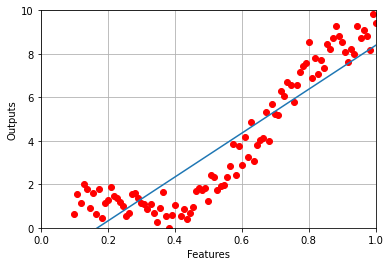

In [149]:
fig, ax = plt.subplots()

# Structure of the plot
plt.grid(True)
plt.xlabel('Features')
plt.ylabel('Outputs')

# Axis limit
ax.set_xlim((0,1))
ax.set_ylim((0,10))

# Plot the data points
ax.plot(x, y, 'ro')

# Animate the model update
l, = ax.plot(x, x_trick.dot(W_updates[0]))
def init():
    l.set_data(x, x_trick.dot(W_updates[0])) 
animate = lambda i: l.set_data(x, x_trick.dot(W_updates[i]))
ani = matplotlib.animation.FuncAnimation(fig, animate, init_func=init, frames=100, interval=30)
ani.save('learning.gif', writer='imagemagick', fps=50)
ani


### Scikit Learn Implementation

In [151]:
regr = skl.LinearRegression()
regr.fit(x, y)
print('----- Optimized parameters:')
print('W: %.4f' % regr.coef_)
print('b: %.4f' % regr.intercept_)

----- Optimized parameters:
W: 10.7402
b: -2.0771


### Pytorch Implementation (built-in backward function)

In [152]:
# Import from numpy arrays
tensor_x = torch.from_numpy(x_trick) # It includes the trick
tensor_y = torch.from_numpy(y)
W = torch.tensor(np.random.rand(2), requires_grad=True) # Need to compute the gradients of W

print('----- Parameters to be optimized:')
print('W:')
print(W[1])
print()
print('b:')
print(W[0])

# Define useful functions
def model(W,x):
    return torch.matmul(x,W)

def mse(y_hat, y):
    error = torch.reshape(y_hat, (-1,1)) - y
    cost = torch.sum(error*error) / (2 * y.shape[0])
    return cost

# Recap of hyper parameters
lr = 0.5
tolerance = 1e-05

print('\n----- Start training...')
iterations = 1
while True:
    preds = model(W, tensor_x)
    loss = mse(preds, tensor_y) # It represents the cost, however the name loss is commonly adopted in Pytorch
    loss.backward()

    with torch.no_grad():
        W_updated = W - W.grad * lr
        if torch.sum(abs(W_updated-W)) < tolerance:
            print('----- Converged\n')
            break
        
        W -= W.grad * lr
        W.grad.zero_()

    if iterations % 50 == 0:
        print('Iteration: %d - Error: %.4f' %(iterations, loss.item()))
    
    iterations += 1

print('----- Optimized parameters:')
print('W: %.4f' % W[1])
print('b: %.4f' % W[0])

----- Parameters to be optimized:
W:
tensor(0.4762, dtype=torch.float64, grad_fn=<SelectBackward>)

b:
tensor(0.3617, dtype=torch.float64, grad_fn=<SelectBackward>)

----- Start training...
Iteration: 50 - Error: 0.9722
Iteration: 100 - Error: 0.7869
Iteration: 150 - Error: 0.7738
Iteration: 200 - Error: 0.7728
Iteration: 250 - Error: 0.7728
Iteration: 300 - Error: 0.7728
Iteration: 350 - Error: 0.7728
----- Converged

----- Optimized parameters:
W: 10.7399
b: -2.0769


### Pytorch Implementation with built-in functions (dataset, backward, optimizer)

In [153]:
# Prepare Pytorch dataset and dataloader
np_inputs = torch.from_numpy(x).float()
np_targets = torch.from_numpy(y).float()
train_dataset = TensorDataset(np_inputs, np_targets)
# Trick for performing the gradient descent using the built-in stochastic gradient descent of Pytorch
batch_size = len(train_dataset) 
train_data_loader = DataLoader(train_dataset, batch_size, shuffle=False)

# Define the model
model = nn.Linear(1, 1)
print('----- Parameters to be optimized:')
print('W:')
print(model.weight)
print()
print('b:')
print(model.bias)

# Define the optimizer
opt = torch.optim.SGD(model.parameters(), lr=0.5)

# Define the loss function
loss_fn = F.mse_loss

# Training process
def fit(model, loss_fn, opt):
    iterations = 1
    print('\n----- Start training...')
    while True:
        for inputs, targets in train_data_loader:
            # Generate predictions
            predictions = model(inputs) # Require conversion from double to float
            loss = loss_fn(predictions, targets)
            
            # Perform gradient descent
            loss.backward()
            W = torch.tensor([model.weight, model.bias]) # Store the paramters before the optimization
            opt.step()
            W_updated = torch.tensor([model.weight, model.bias]) # Store the parameters after the optimization
            
            # Stopping condition defined by the parameters update magnitude
            if torch.sum(abs(W_updated-W)) < tolerance:
                print('-----Converged\n')
                return
            
            opt.zero_grad()

            if iterations % 50 == 0:
                 print("Iteration: %d - Error: %.4f" %(iterations, loss.item()))
            
            iterations += 1

fit(model, loss_fn, opt)

print('----- Optimized parameters:')
print('W:')
print(model.weight)
print()
print('b:')
print(model.bias)


----- Parameters to be optimized:
W:
Parameter containing:
tensor([[0.8619]], requires_grad=True)

b:
Parameter containing:
tensor([0.0543], requires_grad=True)

----- Start training...
Iteration: 50 - Error: 1.5707
Iteration: 100 - Error: 1.5456
Iteration: 150 - Error: 1.5455
Iteration: 200 - Error: 1.5455
-----Converged

----- Optimized parameters:
W:
Parameter containing:
tensor([[10.7401]], requires_grad=True)

b:
Parameter containing:
tensor([-2.0770], requires_grad=True)


## Statistical Measures
### Numpy Implementation
#### $R^2$
Evaluate how much variation in the data is explained by the model.

In [154]:
# Recap of optimized parameters (computed with Pytorch)
W = model.weight.item()
b = model.bias.item()

# Recap of the MSE of model with the learned parameters that fit the data
y_hat = x.dot(W) + b
loss_fit = y_hat - y
mse_fit = np.sum(np.power(loss_fit, 2)) / (2 * n)

# Compute the MSE of the model that always generates the mean value as output
y_mean = np.mean(y)
loss_mean = y_mean - y
mse_mean = np.sum(np.power(loss_mean, 2)) / (2 * n)

def compute_r_squared(f, m):
    """Compute the r_squared value.
    
    The goal of this function is to quantify how the learned model
    fits the data better than the model that produces the mean value of the target.
    In other words, it evaluates how much variation in the data is explained by the model.

    Parameters
    ----------
    f : float64
        MSE computed using the learned model that fit the data
    m : float64
        MSE computed using the model that always produces as output the mean value
        of the target

    Returns
    -------
    r_squared : float64
        R_squared
    """

    # The numerator is the variation of y explained by W and b
    num = (m - f)

    # The denominator is the variation of y computed without taking into account W and b
    den = m 
    
    return num / den

r_squared = compute_r_squared(mse_fit, mse_mean)

print('----- R_Squared: %.4f \n' % r_squared)
    

----- R_Squared: 0.8371 



#### F-statistic
F-statistic is the ratio between the variations of $y$ explained by the extra parameters of the learned model (in our case $W$) compared to the mean model and the the variation of $y$ not explained by the model (represented by the MSE).

In [155]:
# Paramaters to compute the degrees of freedom
p_fit = 2
p_mean = 1

def compute_f_stat(f, m, p_f, p_m, n):
    """
    Compute f_stat

    Parameters:
    -----------
    f : float64
        MSE computed using the learned model that fit the data
    m : float64
        MSE computed using the model that always produces as output the mean value
        of the target
    p_f : int
        Number of parameters the fit the line (W and b)
    p_m : int
        Number of parameters in the mean line (b)
    n : int
        Number of samples in the dataset

    Returns:
    -------
    f_s : float64
    """

    # The numerator is the variation of y explained by the
    # extra parameter of the learned model compared to the mean model. 
    num = (m - f) / (p_f - p_m)

    # The denominator is the variation of y that is not explained by the learned model. 
    # It represent the variation (the residual) that remains after fitting the line (or learning the parameters)
    # It depends on p_fit, because many parameters requires many data samples
    den = f / (n - p_f)

    f_s = np.round(num / den, decimals=2)

    return f_s

f_stat = compute_f_stat(mse_fit, mse_mean, p_fit, p_mean, n)

print('----- F-statistic: %.4f \n' % f_stat)

----- F-statistic: 503.6900 



### Stats Implementation

In [156]:
est = sm.OLS(y, x_trick)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     503.7
Date:                Wed, 06 Jan 2021   Prob (F-statistic):           2.11e-40
Time:                        18:30:40   Log-Likelihood:                -163.66
No. Observations:                 100   AIC:                             331.3
Df Residuals:                      98   BIC:                             336.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0771      0.292     -7.122      0.0